In [221]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0)) 

True
1
NVIDIA RTX A4000


In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import cv2
import numpy as np

C:\Users\FAST\.conda\envs\tens\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("nguyenkhoa/celeba-spoof-for-face-antispoofing-test")

In [3]:
ds

DatasetDict({
    test: Dataset({
        features: ['cropped_image', 'labels', 'labelNames'],
        num_rows: 67170
    })
})

In [4]:
# Extract images and labels
test_dataset = ds["test"]

images = [sample["cropped_image"] for sample in test_dataset]
labels = [sample["labels"] for sample in test_dataset]

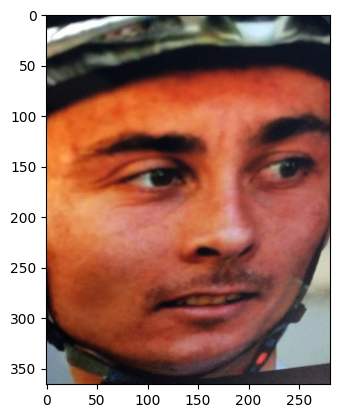

In [5]:
plt.imshow(images[70])

In [177]:
# #convert to numpy array
# images=[np.array(image) for image in images]

In [178]:
# image=cv2.resize(images[0], (780, 540))
# plt.imshow(image)

In [179]:
# labels=np.array(labels)

In [180]:
split_ds = test_dataset.train_test_split(test_size=0.2, shuffle=True)

train_dataset = split_ds["train"]
test_dataset = split_ds["test"]

In [181]:
# Get the numbers of each set
test_num = len(train_dataset)
train_num = len(test_dataset)

val_size = test_num / train_num

train_val_split = train_dataset.train_test_split(test_size=0.10)
train_val_split

DatasetDict({
    train: Dataset({
        features: ['cropped_image', 'labels', 'labelNames'],
        num_rows: 48362
    })
    test: Dataset({
        features: ['cropped_image', 'labels', 'labelNames'],
        num_rows: 5374
    })
})

In [182]:
from datasets import DatasetDict

def clean_dataset(dataset):
    def filter_none(example):
        return example["cropped_image"] is not None and example["labels"] is not None

    cleaned_dataset = DatasetDict({
        "train": dataset["train"].filter(filter_none),
        "validation": dataset["validation"].filter(filter_none),
        "test": dataset["test"].filter(filter_none),
    })
    
    return cleaned_dataset

dataset = DatasetDict({
    "train": train_val_split["train"].shuffle(seed=42).select(range(int(0.2 * len(train_val_split["train"])))),
    "validation": train_val_split["test"].shuffle(seed=42).select(range(int(0.2 * len(train_val_split["test"])))),
    "test": split_ds["test"].shuffle(seed=42).select(range(int(0.2 * len(split_ds["test"])))),
})

dataset = clean_dataset(dataset)

dataset


Filter: 100%|██████████████████████████████████████████████████████████████| 2686/2686 [00:04<00:00, 603.52 examples/s]


DatasetDict({
    train: Dataset({
        features: ['cropped_image', 'labels', 'labelNames'],
        num_rows: 9618
    })
    validation: Dataset({
        features: ['cropped_image', 'labels', 'labelNames'],
        num_rows: 1065
    })
    test: Dataset({
        features: ['cropped_image', 'labels', 'labelNames'],
        num_rows: 2667
    })
})

In [183]:
train_ds = dataset["train"]
val_ds = dataset["validation"]
test_ds = dataset["test"]

In [184]:
train_ds.features

{'cropped_image': Image(mode=None, decode=True, id=None),
 'labels': ClassLabel(names=['live', 'spoof'], id=None),
 'labelNames': Value(dtype='string', id=None)}

In [185]:
id2label = {id: label for id, label in enumerate(train_ds.features["labels"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_ds[0]["labels"]]

({0: 'live', 1: 'spoof'}, 'live')

In [186]:
from transformers import ViTImageProcessor

model_name = "google/vit-large-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

In [187]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)
val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)
test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

In [188]:
def apply_train_transforms(examples):
    if "cropped_image" not in examples or examples["cropped_image"] is None:
        return examples  # Avoid errors if the key is missing

    image = examples["cropped_image"].convert("RGB")  # Convert image to RGB
    pixel_values = train_transforms(image)  # Apply train transformations

    examples["pixel_values"] = torch.tensor(pixel_values, dtype=torch.float32)  # Convert to tensor
    return examples


def apply_val_transforms(examples):
    if "cropped_image" not in examples or examples["cropped_image"] is None:
        return examples  

    image = examples["cropped_image"].convert("RGB")
    pixel_values = val_transforms(image)  # Apply validation transformations

    examples["pixel_values"] = torch.tensor(pixel_values, dtype=torch.float32)
    return examples


def apply_test_transforms(examples):
    if "cropped_image" not in examples or examples["cropped_image"] is None:
        return examples  

    image = examples["cropped_image"].convert("RGB")
    pixel_values = val_transforms(image)  # Use validation transforms for test data

    examples["pixel_values"] = torch.tensor(pixel_values, dtype=torch.float32)
    return examples


In [189]:
from datasets import Features, Image, ClassLabel, Value, Array3D
import torch

# Apply transformations to dataset using map() to permanently add "pixel_values"
train_ds = train_ds.map(apply_train_transforms)
val_ds = val_ds.map(apply_val_transforms)
test_ds = test_ds.map(apply_test_transforms)

# Update dataset schema to explicitly include "pixel_values"
train_ds = train_ds.cast(
    Features({
        "cropped_image": Image(),
        "labels": ClassLabel(names=["live", "spoof"]),
        "labelNames": Value("string"),
        "pixel_values": Array3D(dtype="float32", shape=(3, 224, 224)),  # Adjust shape if necessary
    })
)

val_ds = val_ds.cast(train_ds.features)
test_ds = test_ds.cast(train_ds.features)

# Now we can safely set the format for PyTorch tensors
train_ds = train_ds.with_format("torch", columns=["pixel_values", "labels"])
val_ds = val_ds.with_format("torch", columns=["pixel_values", "labels"])
test_ds = test_ds.with_format("torch", columns=["pixel_values", "labels"])

# Verify dataset features
print(train_ds.features)  # Now it should include "pixel_values"


C:\Users\FAST\AppData\Local\Temp\ipykernel_16036\1595156775.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  examples["pixel_values"] = torch.tensor(pixel_values, dtype=torch.float32)  # Convert to tensor
Map: 100%|██████████████████████████████████████████████████████████████████| 9618/9618 [03:33<00:00, 45.09 examples/s]
C:\Users\FAST\AppData\Local\Temp\ipykernel_16036\1595156775.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  examples["pixel_values"] = torch.tensor(pixel_values, dtype=torch.float32)
Map: 100%|██████████████████████████████████████████████████████████████████| 1065/1065 [00:22<00:00, 46.63 examples/s]
C:\Users\FAST\AppData\Local\Temp\ipykernel_16036\1595156775.

{'cropped_image': Image(mode=None, decode=True, id=None), 'labels': ClassLabel(names=['live', 'spoof'], id=None), 'labelNames': Value(dtype='string', id=None), 'pixel_values': Array3D(shape=(3, 224, 224), dtype='float32', id=None)}


In [190]:
train_ds[0]

{'labels': tensor(0),
 'pixel_values': tensor([[[ 0.5451,  0.5451,  0.6000,  ..., -0.7412, -0.7255, -0.7255],
          [ 0.5373,  0.5373,  0.6000,  ..., -0.7412, -0.7255, -0.7255],
          [ 0.5059,  0.5059,  0.5843,  ..., -0.7412, -0.7255, -0.7255],
          ...,
          [ 0.9765,  0.9765,  0.9843,  ...,  0.1216,  0.1294,  0.1294],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.1216,  0.1294,  0.1294],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.1216,  0.1294,  0.1294]],
 
         [[ 0.2392,  0.2392,  0.3020,  ..., -0.8118, -0.7961, -0.7961],
          [ 0.2314,  0.2314,  0.3020,  ..., -0.8118, -0.7961, -0.7961],
          [ 0.2000,  0.2000,  0.2863,  ..., -0.8118, -0.7961, -0.7961],
          ...,
          [ 0.9451,  0.9451,  0.9373,  ..., -0.3098, -0.3020, -0.3020],
          [ 0.9843,  0.9843,  0.9608,  ..., -0.3098, -0.3020, -0.3020],
          [ 0.9922,  0.9922,  0.9686,  ..., -0.3098, -0.3020, -0.3020]],
 
         [[-0.1059, -0.1059, -0.0510,  ..., -0.8745, -0.8510, 

In [191]:
import torch
from torch.utils.data import DataLoader


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [194]:
batch = next(iter(train_dl))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [195]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [201]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

def transform(example):
    example["pixel_values"] = feature_extractor(example["cropped_image"], return_tensors="pt")["pixel_values"][0]
    return example

# Apply transformation to train and validation sets
dataset["train"] = dataset["train"].map(transform, remove_columns=["cropped_image"])
dataset["validation"] = dataset["validation"].map(transform, remove_columns=["cropped_image"])


Map: 100%|█████████████████████████████████████████████████████████████████| 1065/1065 [00:08<00:00, 131.36 examples/s]


In [210]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",        
    per_device_train_batch_size=32,  # Increased for faster training
    per_device_eval_batch_size=32,   # Increased for faster evaluation
    gradient_accumulation_steps=2,  # Helps with memory efficiency (only if needed)
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=40,
    report_to="none",  # Disable logging to external services like WandB
    logging_dir="./logs",
    logging_steps=100,  # More frequent logging for better tracking
    fp16=False,  # Disable fp16 if using bf16
    bf16=True,   # Enable bf16 for better performance on RTX 40-series GPUs
    optim="adamw_bnb_8bit",  # Use 8-bit Adam optimizer for better memory efficiency
    dataloader_num_workers=4,  # Increase data loading speed
)


In [211]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()


In [218]:
import torch
import numpy as np

# Define a function to compute accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    accuracy = (predictions == torch.tensor(labels)).float().mean()
    return {"accuracy": accuracy.item()}


In [219]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=feature_extractor,  # Use feature extractor for consistency
    data_collator=data_collator,  # Important for batching `pixel_values`
    compute_metrics=compute_metrics,
)

C:\Users\FAST\AppData\Local\Temp\ipykernel_16036\904647656.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [220]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.006600,0.044626,0.990610
2,0.008300,0.030381,0.991549
3,0.006700,0.057498,0.990610
4,0.006400,0.039494,0.991549
5,0.005300,0.143317,0.971831
6,0.002500,0.044408,0.990610
7,0.003200,0.030837,0.994366
8,0.001300,0.036391,0.991549
9,0.000100,0.044129,0.992488
10,0.001000,0.036083,0.994366


TrainOutput(global_step=6000, training_loss=0.0015893884644804833, metrics={'train_runtime': 16081.3001, 'train_samples_per_second': 23.923, 'train_steps_per_second': 0.373, 'total_flos': 1.0469928714932004e+20, 'train_loss': 0.0015893884644804833, 'epoch': 39.737541528239205})

In [222]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.040647584944963455, 'test_accuracy': 0.993250846862793, 'test_runtime': 14.2052, 'test_samples_per_second': 187.748, 'test_steps_per_second': 5.913}


In [224]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Extract logits and convert to predictions
logits = outputs.predictions
predictions = np.argmax(logits, axis=1)  # Get class with highest probability
labels = outputs.label_ids  # True labels from dataset

# Compute Metrics
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions, average="weighted")
recall = recall_score(labels, predictions, average="weighted")
f1 = f1_score(labels, predictions, average="weighted")

# Print Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9933
Precision: 0.9933
Recall: 0.9933
F1-score: 0.9933


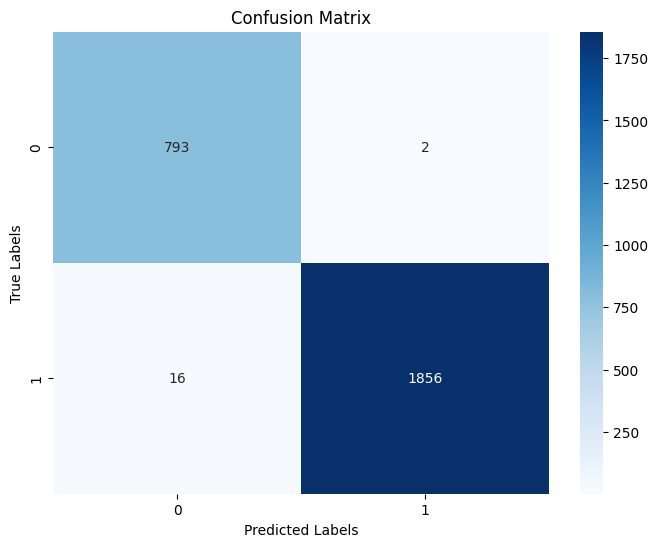

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(labels, predictions)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(labels), yticklabels=set(labels))

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [231]:
from datasets import Dataset
from PIL import Image
from transformers import ViTFeatureExtractor

# Load and preprocess the image
image_path = "image.jpeg"
image = Image.open(image_path).convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt")

# Convert to dataset format
test_ds = Dataset.from_dict({"pixel_values": [torch.tensor(inputs["pixel_values"].squeeze(0))]})
test_ds = Dataset.from_dict({
    "pixel_values": [torch.tensor(inputs["pixel_values"].squeeze(0))],
    "labels": [None]  # or any placeholder if required
})


# Run prediction
outputs = trainer.predict(test_ds)

# Get predicted label
logits = outputs.predictions
predicted_class_idx = np.argmax(logits, axis=-1)[0]

# Define labels
id2label = {0: "Real", 1: "Spoof"} 
print(f"Predicted label: {id2label[predicted_class_idx]}")


C:\Users\FAST\AppData\Local\Temp\ipykernel_16036\8319241.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_ds = Dataset.from_dict({"pixel_values": [torch.tensor(inputs["pixel_values"].squeeze(0))]})
C:\Users\FAST\AppData\Local\Temp\ipykernel_16036\8319241.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "pixel_values": [torch.tensor(inputs["pixel_values"].squeeze(0))],


Predicted label: Real


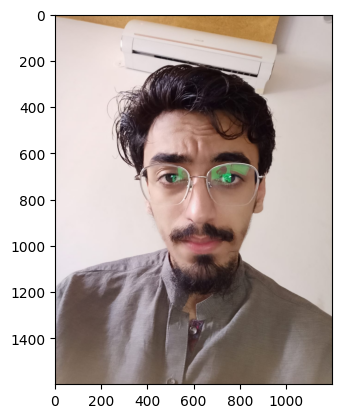

In [9]:
plt.imshow(image)

In [13]:
from datasets import Dataset
from PIL import Image
from transformers import ViTFeatureExtractor

# Load and preprocess the image
image_path = "spoofimages.jpeg"
image = Image.open(image_path).convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt")

# Convert to dataset format
test_ds = Dataset.from_dict({"pixel_values": [torch.tensor(inputs["pixel_values"].squeeze(0))]})
test_ds = Dataset.from_dict({
    "pixel_values": [torch.tensor(inputs["pixel_values"].squeeze(0))],
    "labels": [None]  # or any placeholder if required
})


# Run prediction
outputs = trainer.predict(test_ds)

# Get predicted label
logits = outputs.predictions
predicted_class_idx = np.argmax(logits, axis=-1)[0]

# Define labels
id2label = {0: "Real", 1: "Spoof"}
print(f"Predicted label: {id2label[predicted_class_idx]}")

Predicted label: Spoof


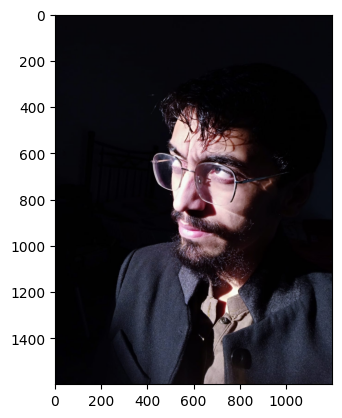

In [11]:
plt.imshow(image)